#### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Config
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#### Constants

In [2]:
DATASET_DIR = '../datasets/CICIDS2017'
DOCS_DIR = './docs'

os.makedirs(DOCS_DIR, exist_ok=True)

#### Loading Datasets

In [3]:
SAMPLE_FILE = f'{DOCS_DIR}/sampled_data.csv'

# CICIDS file paths
file_paths = [
    f'{DATASET_DIR}/Wednesday-workingHours.pcap_ISCX.csv',
    f'{DATASET_DIR}/Tuesday-WorkingHours.pcap_ISCX.csv',
    f'{DATASET_DIR}/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    f'{DATASET_DIR}/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    f'{DATASET_DIR}/Monday-WorkingHours.pcap_ISCX.csv',
    f'{DATASET_DIR}/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    f'{DATASET_DIR}/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    f'{DATASET_DIR}/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

# Check if sample file exists
if os.path.exists(SAMPLE_FILE):
    print(f"✅ Loading sampled dataset from {SAMPLE_FILE}...")
    df = pd.read_csv(SAMPLE_FILE, encoding='latin1')
    print(f"📊 Loaded sampled dataset shape: {df.shape}")
else:
    print(f"⚠️ Sample file not found at {SAMPLE_FILE}. Loading original datasets...")
    
    # Load the original files
    dataframes = []
    for i, path in enumerate(file_paths):
        try:
            df_temp = pd.read_csv(path, encoding='latin1')
            dataframes.append(df_temp)
            print(f"✅ Loaded dataset {i+1}: {df_temp.shape}")
        except FileNotFoundError:
            print(f"⚠️ Warning: File not found - {path}. Skipping...")
        except Exception as e:
            print(f"❌ Error loading {path}: {str(e)}")

    # Handle result
    if not dataframes:
        print("⚠️ No datasets loaded. Creating sample data for demonstration...")
        np.random.seed(42)
        n_samples = 10000
        n_features = 80  # Adjust based on typical CICIDS dataset feature count

        X_sample = np.random.randn(n_samples, n_features)
        y_sample = np.random.choice(['BENIGN', 'DDoS', 'DoS Hulk', 'Web Attack'],
                                    size=n_samples, p=[0.7, 0.1, 0.1, 0.1])

        feature_names = [f'feature_{i}' for i in range(n_features)]  # Generic feature names
        df = pd.DataFrame(X_sample, columns=feature_names)
        df['Label'] = y_sample
    else:
        df = pd.concat(dataframes, ignore_index=True)
        print(f"📦 Combined dataset shape: {df.shape}")

        # Sample 10% of the data
        df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
        print(f"📊 Sampled dataset shape: {df.shape}")

        # Save the sampled dataset
        try:
            df.to_csv(SAMPLE_FILE, index=False)
            print(f"✅ Sampled dataset saved to {SAMPLE_FILE}")
        except Exception as e:
            print(f"❌ Error saving sampled dataset: {str(e)}")

print("✅ Data loading completed!")

⚠️ Sample file not found at ./docs/sampled_data.csv. Loading original datasets...
✅ Loaded dataset 1: (692703, 85)
✅ Loaded dataset 2: (445909, 85)
✅ Loaded dataset 3: (458968, 85)
✅ Loaded dataset 4: (288602, 85)
✅ Loaded dataset 5: (529918, 85)
✅ Loaded dataset 6: (191033, 85)
✅ Loaded dataset 7: (225745, 85)
✅ Loaded dataset 8: (286467, 85)
📦 Combined dataset shape: (3119345, 85)
📊 Sampled dataset shape: (623869, 85)
✅ Sampled dataset saved to ./docs/sampled_data.csv
✅ Data loading completed!


In [4]:
# Display basic info
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.info())


DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623869 entries, 0 to 623868
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       566047 non-null  object 
 1    Source IP                    566047 non-null  object 
 2    Source Port                  566047 non-null  float64
 3    Destination IP               566047 non-null  object 
 4    Destination Port             566047 non-null  float64
 5    Protocol                     566047 non-null  float64
 6    Timestamp                    566047 non-null  object 
 7    Flow Duration                566047 non-null  float64
 8    Total Fwd Packets            566047 non-null  float64
 9    Total Backward Packets       566047 non-null  float64
 10  Total Length of Fwd Packets   566047 non-null  float64
 11   Total Length of Bwd Packets  566047 non-null  float64
 12   Fwd Packet Length Max    

In [5]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.17-72.167.18.239-55220-80-6,192.168.10.17,55220.0,72.167.18.239,80.0,6.0,4/7/2017 11:04,155.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.14-53-64644-17,192.168.10.14,64644.0,192.168.10.3,53.0,17.0,4/7/2017 2:39,47536.0,2.0,2.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-213.180.204.92-49163-443-6,192.168.10.5,49163.0,213.180.204.92,443.0,6.0,03/07/2017 02:44:01,4755.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.14-53-60505-17,192.168.10.14,60505.0,192.168.10.3,53.0,17.0,4/7/2017 9:48,193.0,2.0,2.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.1-192.168.10.3-53-61857-17,192.168.10.3,61857.0,192.168.10.1,53.0,17.0,6/7/2017 1:26,162586.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


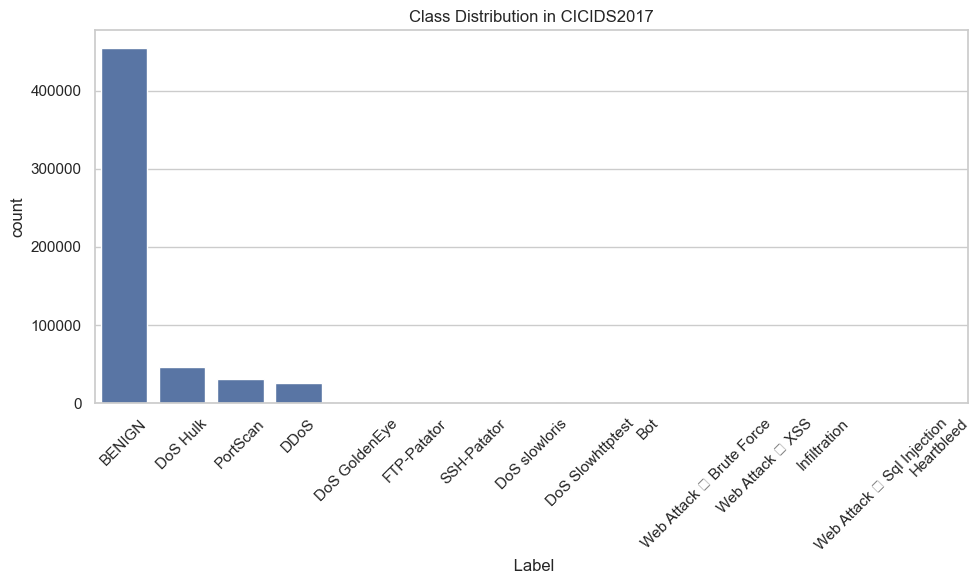

In [6]:
# 1. Bar Plot: Class Distribution (Seaborn)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df.iloc[:, -1], order=df.iloc[:, -1].value_counts().index)
plt.title('Class Distribution in CICIDS2017')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

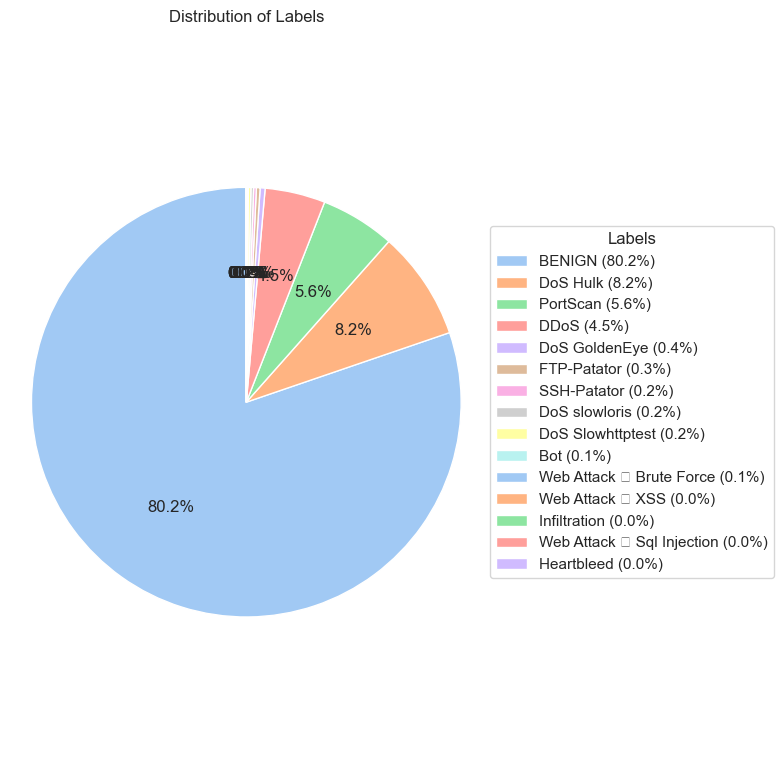

In [7]:
# Label column
label = df.iloc[:, -1]

# Count of each label
value_counts = label.value_counts()
total = value_counts.sum()
percentages = (value_counts / total * 100).round(1)

# Colors
colors = sns.color_palette("pastel", len(value_counts))

# Create pie chart without labels on the slices
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    value_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Create custom legend labels: "Label (X.X%)"
legend_labels = [
    f"{label} ({percentages[label]}%)" for label in value_counts.index
]

# Add legend with labels and matching colors
plt.legend(patches, legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

# Title and layout
plt.title('Distribution of Labels')
plt.axis('equal')
plt.tight_layout()
plt.show()

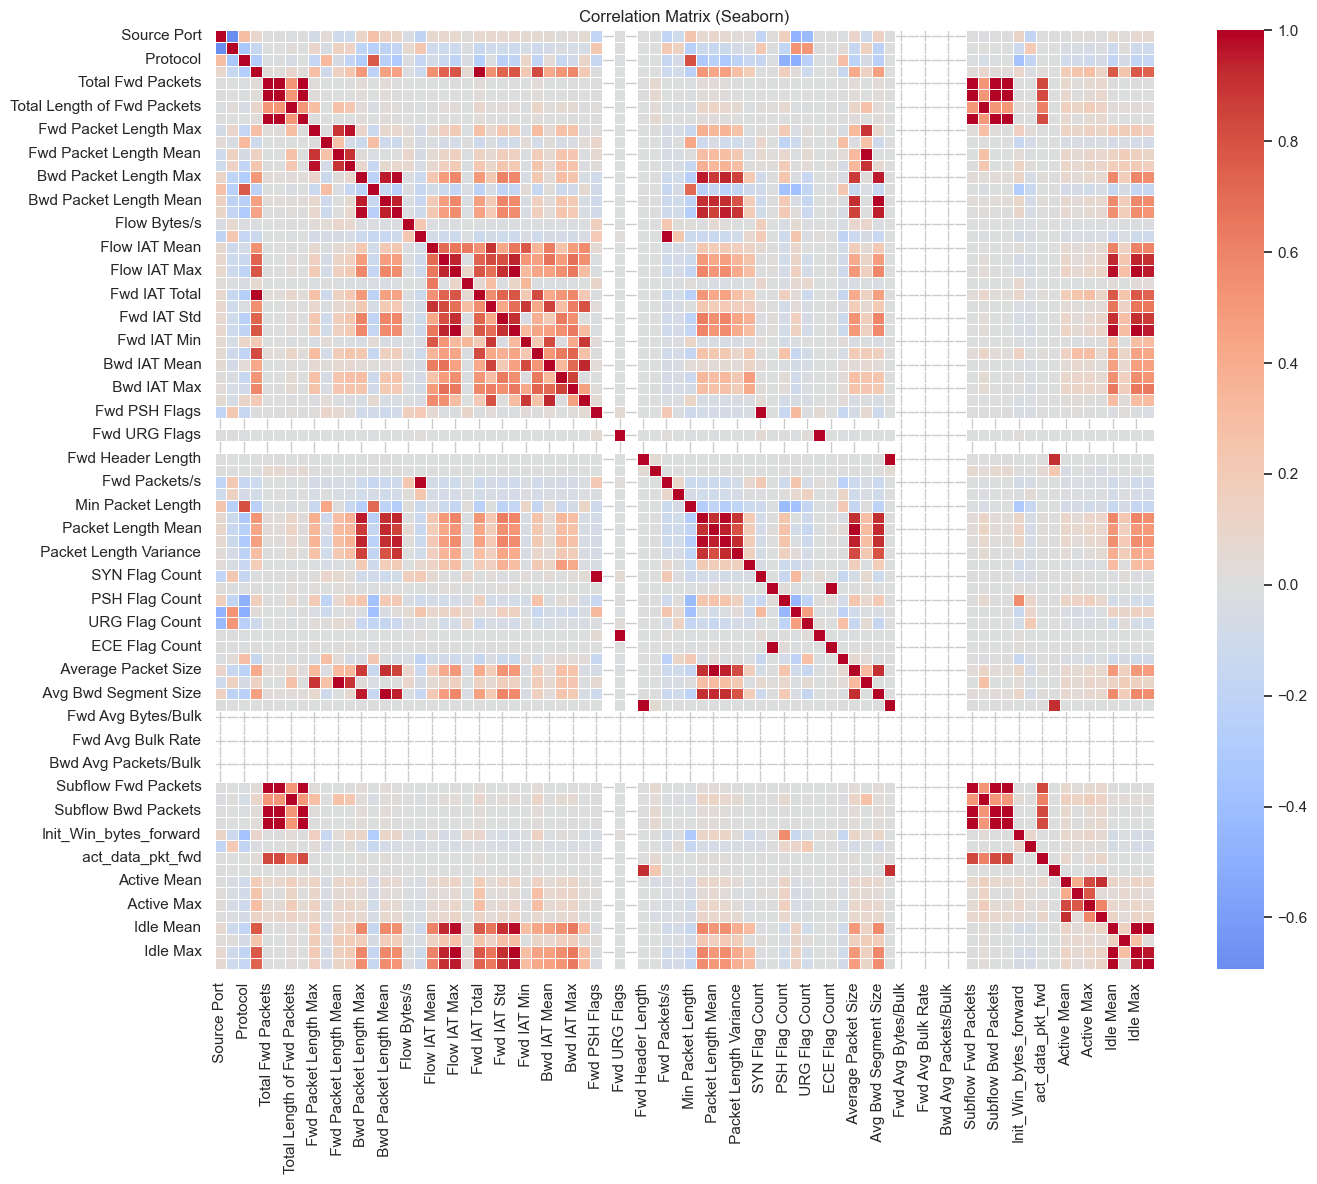

In [8]:

# Seaborn heatmap
numerical_df = df.select_dtypes(include=[np.number])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix (Seaborn)')
plt.tight_layout()
plt.show()

#### OUTLIER DETECTION VISUALIZATION

In [9]:
# 5.1 Z-score based outlier detection
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.dropna()))
    return z_scores > threshold

In [10]:
# 5.2 Outlier counts for each feature
outlier_counts = {}
for col in df.iloc[:,7:-1]:  # First 10 features
    outliers = detect_outliers_zscore(df[col])
    outlier_counts[col] = outliers.sum()


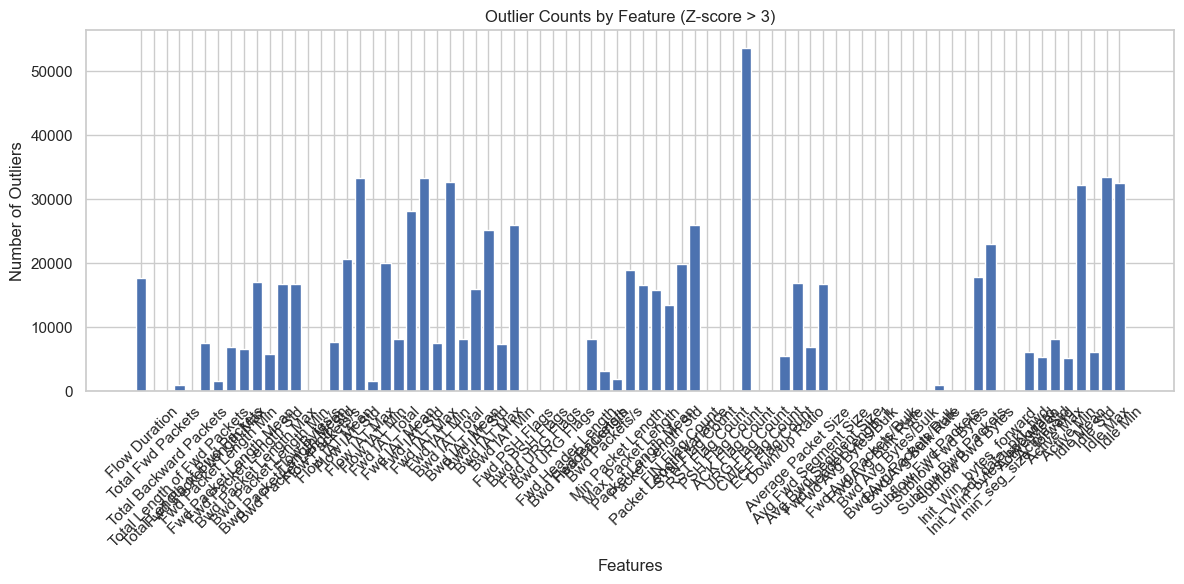

In [11]:
# Plot outlier counts
plt.figure(figsize=(12, 6))
plt.bar(outlier_counts.keys(), outlier_counts.values())
plt.title('Outlier Counts by Feature (Z-score > 3)')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.17-72.167.18.239-55220-80-6,192.168.10.17,55220.0,72.167.18.239,80.0,6.0,4/7/2017 11:04,155.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.14-53-64644-17,192.168.10.14,64644.0,192.168.10.3,53.0,17.0,4/7/2017 2:39,47536.0,2.0,2.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-213.180.204.92-49163-443-6,192.168.10.5,49163.0,213.180.204.92,443.0,6.0,03/07/2017 02:44:01,4755.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.14-53-60505-17,192.168.10.14,60505.0,192.168.10.3,53.0,17.0,4/7/2017 9:48,193.0,2.0,2.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.1-192.168.10.3-53-61857-17,192.168.10.3,61857.0,192.168.10.1,53.0,17.0,6/7/2017 1:26,162586.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623864,192.168.10.16-192.168.10.50-36122-22-6,192.168.10.50,22.0,192.168.10.16,36122.0,6.0,7/7/2017 3:09,83.0,1.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
623865,192.168.10.1-192.168.10.3-53-60894-17,192.168.10.3,60894.0,192.168.10.1,53.0,17.0,6/7/2017 2:37,30541.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
623866,178.239.182.230-192.168.10.25-443-57861-6,192.168.10.25,57861.0,178.239.182.230,443.0,6.0,03/07/2017 12:50:47,581767.0,13.0,8.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
623867,192.168.10.12-68.67.178.110-53652-80-6,192.168.10.12,53652.0,68.67.178.110,80.0,6.0,5/7/2017 10:36,15324074.0,11.0,16.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
